<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/work_from_here/new_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance --q


In [10]:
import pandas as pd
import numpy as np

def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
def calculate_bollinger_bands(data, period=20):
    sma = data['Close'].rolling(window=period).mean()
    std_dev = data['Close'].rolling(window=period).std()
    upper_band = sma + (std_dev * 2)
    lower_band = sma - (std_dev * 2)
    return upper_band, lower_band

def calculate_force_index(data, period=13):
    fi = (data['Close'] - data['Close'].shift()) * data['Volume']
    fi_ema = fi.ewm(span=period).mean()
    return fi_ema

def calculate_moving_averages(data, short_period=20, long_period=50):
    short_ma = data['Close'].rolling(window=short_period).mean()
    long_ma = data['Close'].rolling(window=long_period).mean()
    trend_direction = np.where(short_ma > long_ma, 1, -1)
    return trend_direction

def calculate_vortex_indicator(data, period=14):
    tr = pd.DataFrame(data['High'] - data['Low'])
    tr['H-L'] = abs(data['High'] - data['Low'])
    tr['H-PC'] = abs(data['High'] - data['Close'].shift())
    tr['L-PC'] = abs(data['Low'] - data['Close'].shift())

    tr['TR'] = tr.max(axis=1)

    data['VM'] = abs(data['High'].shift() - data['Low'])
    data['VP'] = abs(data['Low'].shift() - data['High'])

    data['VM14'] = data['VM'].rolling(window=period).sum()
    data['VP14'] = data['VP'].rolling(window=period).sum()
    data['TR14'] = tr['TR'].rolling(window=period).sum()

    data['VI+'] = data['VP14'] / data['TR14']
    data['VI-'] = data['VM14'] / data['TR14']

    return data['VI+'] - data['VI-']

def calculate_tsfi(data, rsi_period=14, fi_period=13, short_ma_period=20, long_ma_period=50, bb_period=20, vi_period=14, rsi_weight=0.25, fi_weight=0.25, bb_weight=0.25, vi_weight=0.25):
    data['RSI'] = calculate_rsi(data, rsi_period)
    data['ForceIndex'] = calculate_force_index(data, fi_period)
    data['TrendDirection'] = calculate_moving_averages(data, short_ma_period, long_ma_period)
    data['UpperBB'], data['LowerBB'] = calculate_bollinger_bands(data, bb_period)
    data['VortexIndex'] = calculate_vortex_indicator(data, vi_period)

    # Calculate Bollinger Band volatility
    data['BBVolatility'] = (data['UpperBB'] - data['LowerBB']) / data['Close']

    data['NormalizedRSI'] = data['RSI'] / 100
    data['NormalizedForceIndex'] = data['ForceIndex'] / data['ForceIndex'].abs().max()
    data['NormalizedBBVolatility'] = data['BBVolatility'] / data['BBVolatility'].abs().max()
    data['NormalizedVortexIndex'] = data['VortexIndex'] / data['VortexIndex'].abs().max()

    data['WeightedAverage'] = (data['NormalizedRSI'] * rsi_weight) + (data['NormalizedForceIndex'] * fi_weight) + (data['NormalizedBBVolatility'] * bb_weight) + (data['NormalizedVortexIndex'] * vi_weight)
    data['TSFI'] = data['WeightedAverage'] * data['TrendDirection']

    return data




[*********************100%***********************]  1 of 1 completed


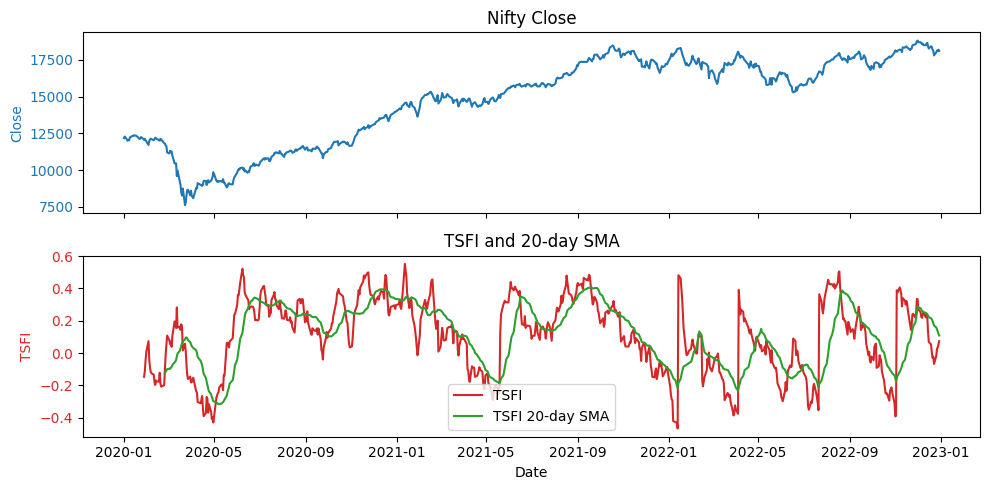

In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download Nifty historical data
nifty = yf.download('^NSEI', start='2020-01-01', end='2023-01-01')

# Calculate TSFI for Nifty data
nifty_tsfi = calculate_tsfi(nifty)

# Calculate 20-day SMA of TSFI
nifty_tsfi['TSFI_SMA20'] = nifty_tsfi['TSFI'].rolling(window=20).mean()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

# Plot Nifty Close price
ax1.set_ylabel('Close', color='tab:blue')
ax1.plot(nifty_tsfi.index, nifty_tsfi['Close'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Close')

# Plot TSFI
ax2.set_xlabel('Date')
ax2.set_ylabel('TSFI', color='tab:red')
ax2.plot(nifty_tsfi.index, nifty_tsfi['TSFI'], color='tab:red', label='TSFI')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot 20-day SMA of TSFI
ax2.plot(nifty_tsfi.index, nifty_tsfi['TSFI_SMA20'], color='tab:green', label='TSFI 20-day SMA')
ax2.legend(loc='best')

ax2.set_title('TSFI and 20-day SMA')

fig.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


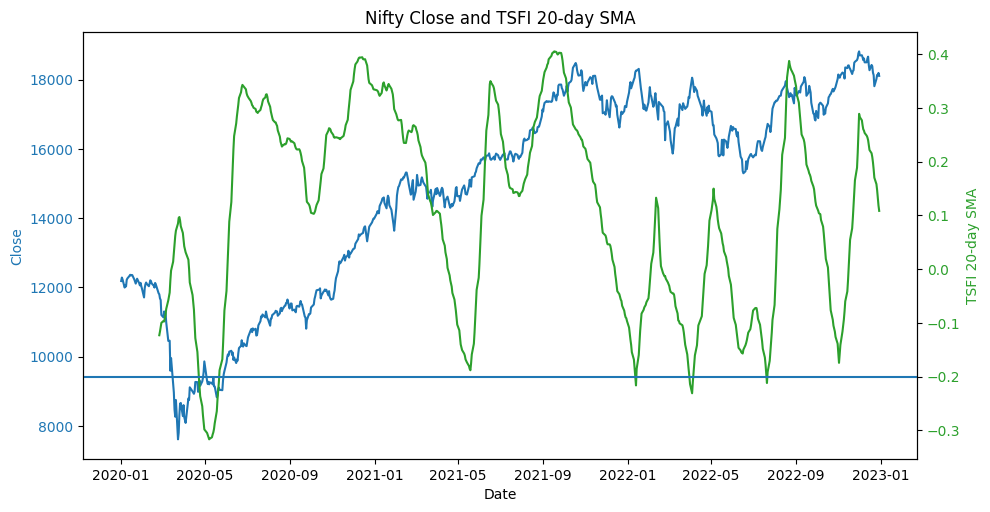

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download Nifty historical data
nifty = yf.download('^NSEI', start='2020-01-01', end='2023-01-01')

# Calculate TSFI for Nifty data
nifty_tsfi = calculate_tsfi(nifty)

# Calculate 20-day SMA of TSFI
nifty_tsfi['TSFI_SMA20'] = nifty_tsfi['TSFI'].rolling(window=20).mean()

# Create subplots
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Nifty Close price
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='tab:blue')
ax1.plot(nifty_tsfi.index, nifty_tsfi['Close'], color='tab:blue', label='Nifty Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot 20-day SMA of TSFI
ax2 = ax1.twinx()
ax2.set_ylabel('TSFI 20-day SMA', color='tab:green')
ax2.plot(nifty_tsfi.index, nifty_tsfi['TSFI_SMA20'], color='tab:green', label='TSFI 20-day SMA')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.axhline(y=-0.2)
# Set title and legend
fig.tight_layout()
plt.title('Nifty Close and TSFI 20-day SMA')

# Create a unified legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1


[*********************100%***********************]  1 of 1 completed


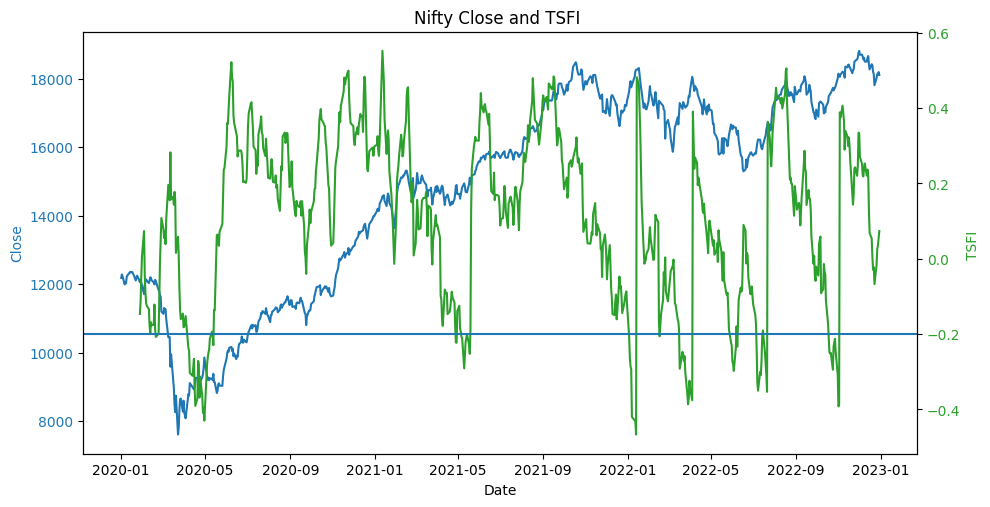

In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download Nifty historical data
nifty = yf.download('^NSEI', start='2020-01-01', end='2023-01-01')

# Calculate TSFI for Nifty data
nifty_tsfi = calculate_tsfi(nifty)

# Calculate 20-day SMA of TSFI
nifty_tsfi['TSFI_SMA20'] = nifty_tsfi['TSFI'].rolling(window=20).mean()

# Create subplots
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Nifty Close price
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='tab:blue')
ax1.plot(nifty_tsfi.index, nifty_tsfi['Close'], color='tab:blue', label='Nifty Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot 20-day SMA of TSFI
ax2 = ax1.twinx()
ax2.set_ylabel('TSFI ', color='tab:green')
ax2.plot(nifty_tsfi.index, nifty_tsfi['TSFI'], color='tab:green', label='TSFI ')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.axhline(y=-0.2)
# Set title and legend
fig.tight_layout()
plt.title('Nifty Close and TSFI ')

# Create a unified legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1